#### 函数的运行机制
##### 函数对象和代码对象

In [1]:
# 每当定义了一个函数之后，就得到了一个函数对象。
def func():
    print("hola")

func

<function __main__.func()>

In [2]:
# 函数中的代码保存在代码对象中。代码对象随着函数对象的创建而创建，可以通过函数对象的 __code__ 属性访问代码对象。    
func.__code__

for attr in dir(func.__code__):
    if attr.startswith('co_'):
        print(attr)

co_argcount
co_cellvars
co_code
co_consts
co_filename
co_firstlineno
co_flags
co_freevars
co_kwonlyargcount
co_lines
co_linetable
co_lnotab
co_name
co_names
co_nlocals
co_posonlyargcount
co_stacksize
co_varnames


In [3]:
# 函数运行帧
# 函数对象和代码对象保存了函数的基本信息，当函数运行的时候，还需要一个对象来保存运行时的状态，即 帧对象。
# 每一次调用函数，都会自动创建一个帧对象，记录当次运行的状态。
import inspect

def foo():
    return inspect.currentframe()

f1 = foo()
f1

<frame at 0x00000263827DB0B0, file 'C:\\Users\\27008\\AppData\\Local\\Temp\\ipykernel_42044\\2506255084.py', line 7, code foo>

Graph written to C:\Users\27008\AppData\Local\Temp\objgraph-uyd71b_r.dot (19 nodes)
Graph viewer (xdot) and image renderer (dot) not found, not doing anything else


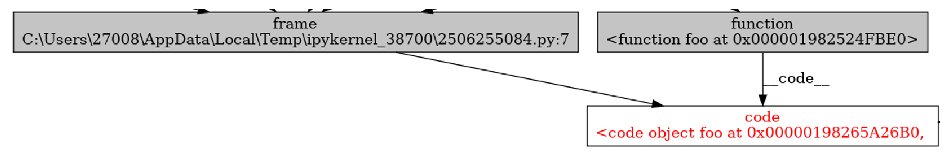

In [4]:
f2 = foo()

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_graph(path):
    img = mpimg.imread(path)
    plt.figure(figsize=(12, 8))
    plt.imshow(img, interpolation='none')
    plt.axis('off')
    plt.show()

# 函数对象、代码对象和帧对象之间的关系
from objgraph import show_backrefs
show_backrefs(foo.__code__)
show_graph("figs/func_code_frame.png")

#### 函数运行栈
>- 当一个函数中调用了另一个函数，此时前一个函数还没有结束，所以这两个函数的帧对象是同时存在的。
>- 比如，我们的程序一般都始于一个 main 函数，然后又调用其它函数，以此类推。
>- 因此，一个程序的运行期，同时存在很多个帧对象。
>- 函数之间的调用关系是先执行的后退出，所以帧对象之间的关系也是先入后出，正好以栈的形式保存。
>- 因此，函数的运行帧又称为栈帧。
>- 注意：一个线程只有一个函数运行栈。

Graph written to C:\Users\27008\AppData\Local\Temp\objgraph-vbg2pwt0.dot (42 nodes)
Graph viewer (xdot) and image renderer (dot) not found, not doing anything else


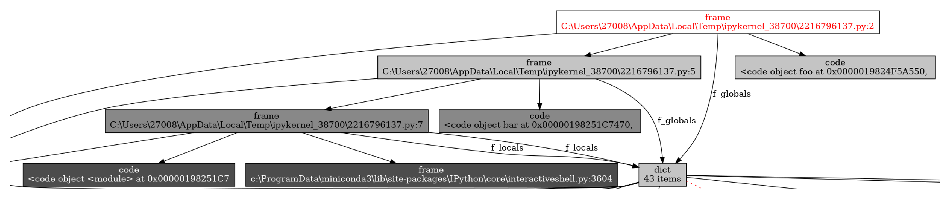

In [5]:
def foo():
    return inspect.currentframe()

def bar():
    return foo() # 返回 foo() 的帧对象

f1 = bar()
from objgraph import show_refs
show_refs(f1)
show_graph("figs/call_stack.png")

Graph written to C:\Users\27008\AppData\Local\Temp\objgraph-9ysu_b5i.dot (39 nodes)
Graph viewer (xdot) and image renderer (dot) not found, not doing anything else


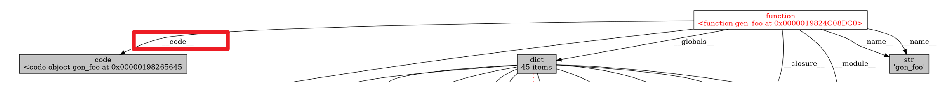

In [6]:
#### 生成器函数
###### 生成器函数仍然是函数对象，当然也包括代码对象。
import inspect
def gen_foo():
    for _ in range(3):
        yield inspect.currentframe()

show_refs(gen_foo)
show_graph("figs/generate_function.png")

Graph written to C:\Users\27008\AppData\Local\Temp\objgraph-i6k7wlx_.dot (23 nodes)
Graph viewer (xdot) and image renderer (dot) not found, not doing anything else


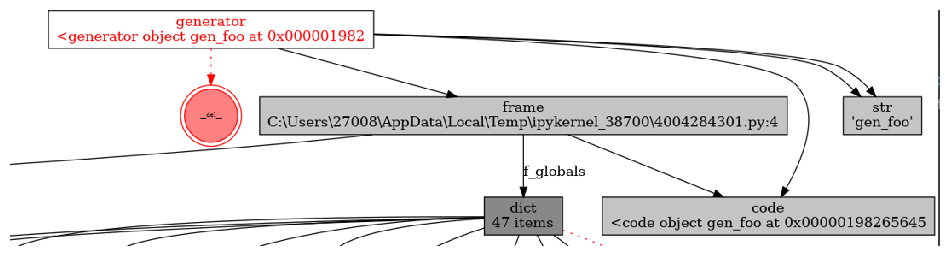

In [7]:
##### 调用生成器函数不会立即运行函数代码，而是返回一个生成器对象。
gf = gen_foo()
show_refs(gf)
show_graph("figs/generate_object.png")
# 如下图所示，生成器自带 frame 属性，保存生成器函数的帧对象。

In [8]:
# 每次使用next()驱动生成器运行时，都会更新这个帧对象(gi_frame)，保存当前的运行状态。
gf = gen_foo()

# 存为变量，不然迭代结束后，frame会变成None
gi_frame = gf.gi_frame

frames = list(gf)

print(gf.gi_frame)

for f in frames:
    print(f is gi_frame)

None
True
True
True


###### 总结
>- 生成器函数并不直接运行，而是借助于生成器对象来间接运行
>- 创建生成器对象的同时创建了帧对象，并且由生成器对象保持引用
>- 每次使用 next () 调用生成器时，就是将生成器引用的帧对象入栈
>- 当 next () 返回时，也就是代码遇到 yield 暂停的时候，就是将帧出栈
>- 直到迭代结束，帧最后一次出栈，并且被销毁

#### 同步和异步
##### 普通函数：
>- 调用函数：构建帧对象并入栈
>- 函数执行结束：帧对象出栈并销毁
##### 生成器函数：
>- 创建生成器：构建帧对象
>- （多次）通过 next 触发执行：帧入栈
>- （多次）遇到 yield：帧出栈（保留）
>- 迭代结束：帧出栈并销毁

#### 从生成器到协程
generator iterator：「生成器对象」是一个用来迭代执行「生成器函数」的迭代器
>- 数据的迭代器：针对一个包含很多元素的数据集，逐个返回其中的元素
>- 生成器迭代器：针对一个包含很多代码的函数，分段执行其中代码

让一个函数可以多次迭代运行其中的代码才是生成器对象最最根本的作用，而不仅是字面意思上的生成数据的东西。

迭代产出数据只是迭代执行代码的自然结果而已。

当用生成器来实现迭代器的时候，我们关注的是重点是：yield <value> 返回出来的数据。

如果把焦点集中到「被迭代执行的代码」上，就能对生成器有个全新的视角，那就是「协程」。